In [1]:
import joblib
import xgboost
import lightgbm
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/train_data.csv")
data

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,STABLER FRANK,500000.0,NaN,NaN,NaN,frank.stabler@enron.com,NaN,16514.0,NaN,NaN,...,NaN,356071.0,False,511734.0,NaN,239502.0,NaN,NaN,1112087.0,511734.0
109,BROWN MICHAEL,NaN,NaN,NaN,NaN,michael.brown@enron.com,NaN,49288.0,41.0,13.0,...,NaN,NaN,False,NaN,NaN,NaN,761.0,1486.0,49288.0,NaN
110,PICKERING MARK R,300000.0,NaN,NaN,NaN,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,...,NaN,NaN,False,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0
111,HAUG DAVID L,NaN,NaN,NaN,NaN,david.haug@enron.com,NaN,475.0,19.0,4.0,...,NaN,NaN,False,2217299.0,NaN,NaN,471.0,573.0,475.0,2217299.0


In [3]:
def process_data(data):
    data = data.query('name!="THE TRAVEL AGENCY IN THE PARK"')
    data = data.query('name!="LOCKHART EUGENE E"')
    drop_feature = ["email_address", "name"]
    data = data.drop(labels=drop_feature, axis=1)
    col = data.columns.tolist()
    imputer = SimpleImputer(missing_values=np.nan, copy=False, strategy="mean")
    imputer = imputer.fit(data)
    data = imputer.transform(data)
    data = pd.DataFrame(data, columns=col)
    print(f"Shape of data: {data.shape}")
    return data

In [4]:
def split(data):
    feature = data.copy()
    label = feature.pop("poi").astype(int)
    return feature, label

In [5]:
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_features.csv")
train_data = process_data(train_data)
test_data = process_data(test_data)

Shape of data: (111, 20)
Shape of data: (33, 19)


In [6]:
def expand_features(data):
    data.loc[:, "salary_p"] = data.loc[:, "salary"]/data.loc[:, "total_payments"]
    data.loc[:, "deferral_payments_p"] = data.loc[:, "deferral_payments"]/data.loc[:, "total_payments"]
    data.loc[:, "loan_advances_p"] = data.loc[:, "loan_advances"]/data.loc[:, "total_payments"]
    data.loc[:, "bonus_p"] = data.loc[:, "bonus"]/data.loc[:, "total_payments"]
    data.loc[:, "deferred_income_p"] = data.loc[:, "deferred_income"]/data.loc[:, "total_payments"]
    data.loc[:, "expenses_p"] = data.loc[:, "expenses"]/data.loc[:, "total_payments"]
    data.loc[:, "other_p"] = data.loc[:, "other"]/data.loc[:, "total_payments"]
    data.loc[:, "long_term_incentive_p"] = data.loc[:, "long_term_incentive"]/data.loc[:, "total_payments"]
    data.loc[:, "director_fees_p"] = data.loc[:, "director_fees"]/data.loc[:, "total_payments"]
    data.loc[:, "restricted_stock_deferred_p"] = data.loc[:, "restricted_stock_deferred"]/data.loc[:, "total_stock_value"]
    data.loc[:, "exercised_stock_options_p"] = data.loc[:, "exercised_stock_options"]/data.loc[:, "total_stock_value"]
    data.loc[:, "restricted_stock_p"] = data.loc[:, "restricted_stock"]/data.loc[:, "total_stock_value"]
    data.loc[:, "from_poi_to_this_person_p"] = data.loc[:, "from_poi_to_this_person"]/data.loc[:, "to_messages"]
    data.loc[:, "shared_receipt_with_poi_p"] = data.loc[:, "shared_receipt_with_poi"]/data.loc[:, "to_messages"]
    data.loc[:, "from_this_person_to_poi_p"] = data.loc[:, "from_this_person_to_poi"]/data.loc[:, "from_messages"]
    data.loc[:, "long_term_incentive_p"] = data.loc[:, "long_term_incentive"]/data.loc[:, "total_payments"]
    data.loc[:, "restricted_stock_deferred_p"] = data.loc[:, "restricted_stock_deferred"]/data.loc[:, "total_stock_value"]
    data.loc[:, "from_this_person_to_poi_p"] = data.loc[:, "from_this_person_to_poi"]/data.loc[:, "from_messages"]
    data.drop("long_term_incentive", axis=1)
    data.drop("restricted_stock_deferred", axis=1)
    data.drop("from_this_person_to_poi", axis=1)
    return data

In [7]:
train_expand = expand_features(train_data)
test_expand = expand_features(test_data)
train_expand

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,expenses_p,other_p,long_term_incentive_p,director_fees_p,restricted_stock_deferred_p,exercised_stock_options_p,restricted_stock_p,from_poi_to_this_person_p,shared_receipt_with_poi_p,from_this_person_to_poi_p
0,1.750000e+06,634437.428571,-3.504386e+06,89397.846154,1.979418e+07,46950.0,18.000000,42.0,4.000000,40962500.0,...,0.092961,0.346182,3.201685,0.177008,-0.009843,0.878081,0.121919,0.046409,0.954696,0.222222
1,5.600000e+06,634437.428571,-4.625664e+05,89397.846154,1.925000e+07,29336.0,108.000000,88.0,30.000000,40962500.0,...,0.003379,0.002548,0.221129,0.010296,-0.008503,0.737727,0.262273,0.024262,0.563000,0.277778
2,2.000000e+05,634437.428571,-4.167000e+03,89397.846154,1.624396e+06,22884.0,39.000000,13.0,14.000000,40962500.0,...,0.011420,0.785137,0.395540,0.044612,-0.088982,0.651422,0.348578,0.057778,0.404444,0.358974
3,8.000000e+05,634437.428571,-4.625664e+05,89397.846154,2.985081e+06,118134.0,711.323077,64.8,40.092308,40962500.0,...,0.044535,0.342116,0.227199,0.033702,-0.225257,3.030440,1.000000,0.030055,0.515463,0.056363
4,1.250000e+06,634437.428571,-2.625000e+05,89397.846154,2.985081e+06,35818.0,144.000000,199.0,25.000000,40962500.0,...,0.021850,0.000296,0.228942,0.054534,-1.760620,23.686042,1.000000,0.076597,0.842186,0.173611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,5.000000e+05,634437.428571,-4.625664e+05,89397.846154,2.985081e+06,16514.0,711.323077,64.8,40.092308,40962500.0,...,0.014850,0.320183,0.712729,0.080387,-0.433596,5.833266,1.000000,0.030055,0.515463,0.056363
107,1.147436e+06,634437.428571,-4.625664e+05,89397.846154,2.985081e+06,49288.0,41.000000,13.0,1.000000,40962500.0,...,1.000000,9.098129,16.081340,1.813785,-0.062908,0.846319,0.367112,0.008748,0.512113,0.024390
108,3.000000e+05,634437.428571,-4.625664e+05,89397.846154,2.879800e+04,31653.0,67.000000,7.0,0.000000,400000.0,...,0.022826,0.323381,0.571589,0.064469,-7.704900,1.000000,44.963358,0.007795,0.810690,0.000000
109,1.147436e+06,634437.428571,-4.625664e+05,89397.846154,2.985081e+06,475.0,19.000000,4.0,7.000000,40962500.0,...,1.000000,944.060155,1668.667583,188.205992,-0.100070,1.346269,1.000000,0.006981,0.821990,0.368421


In [8]:
train_feature, train_label = split(train_expand)
col = train_feature.columns.tolist()
mm = MinMaxScaler()
train_feature = mm.fit_transform(train_feature)
test_feature = mm.transform(test_expand)
train_feature = pd.DataFrame(train_feature, columns=col)
test_feature = pd.DataFrame(test_feature, columns=col)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_feature, train_label, 
                                                                      test_size=0.25, 
                                                                      stratify=train_label, 
                                                                      random_state=43)

In [9]:
print("Train feature size: ", X_train.shape)
print("Valid feature size: ", X_valid.shape)
print("Train label size: ", y_train.shape)
print("Valid label size: ", y_valid.shape)

Train feature size:  (83, 34)
Valid feature size:  (28, 34)
Train label size:  (83,)
Valid label size:  (28,)


In [10]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
X_train_copy.loc[:, "fold"] = "train"
X_valid_copy.loc[:, "fold"] = "valid"
train_temp = pd.concat([X_train_copy, y_train], axis=1)
valid_temp = pd.concat([X_valid_copy, y_valid], axis=1)
df_temp = pd.concat([train_temp, valid_temp], axis=0)
df_temp

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,long_term_incentive_p,director_fees_p,restricted_stock_deferred_p,exercised_stock_options_p,restricted_stock_p,from_poi_to_this_person_p,shared_receipt_with_poi_p,from_this_person_to_poi_p,fold,poi
69,0.135868,0.240279,0.868262,0.707298,0.000190,0.222612,0.048713,0.122727,0.097548,0.5,...,0.000050,0.000048,0.664125,0.007953,0.406997,0.186601,0.505802,0.056363,train,0
100,0.135868,0.240279,0.868262,0.707298,0.019248,0.222612,0.014140,0.047348,0.004866,0.5,...,0.000050,0.000048,0.962619,0.039978,0.396759,0.108316,0.342018,0.009302,train,0
94,0.135868,0.240279,0.998841,0.707298,0.117713,0.245623,0.001184,0.073864,0.000000,0.5,...,0.000155,0.000138,0.986712,0.035612,0.399593,0.427808,0.817260,0.000000,train,0
22,0.054224,0.240279,0.868262,0.707298,0.023939,0.001977,0.007871,0.000000,0.000000,0.5,...,0.000047,0.000120,0.972184,0.037380,0.397590,0.000000,0.002811,0.000000,train,0
2,0.016393,0.240279,0.999108,0.707298,0.047201,0.099451,0.001881,0.024621,0.034063,0.5,...,0.000067,0.000062,0.989031,0.030552,0.399773,0.358725,0.392837,0.358974,train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.155107,0.240279,0.604660,0.707298,0.086819,0.243960,0.048713,0.122727,0.097548,0.5,...,0.000127,0.000051,0.984529,0.073148,0.408537,0.186601,0.505802,0.056363,valid,1
63,0.079445,0.240279,0.868262,0.707298,0.086819,0.161949,0.301686,0.272727,0.939173,0.5,...,0.000146,0.000130,0.771946,1.000000,0.408537,0.122222,0.348392,0.088879,valid,0
71,0.135868,0.240279,0.993161,0.866249,0.012475,0.222612,0.048713,0.122727,0.097548,0.5,...,0.001761,0.001851,0.987324,0.045222,0.396457,0.186601,0.505802,0.056363,valid,0
73,0.135868,0.240279,0.970683,0.825181,0.086819,0.000000,0.048713,0.122727,0.097548,0.5,...,1.000000,1.000000,0.992417,0.038754,0.400022,0.186601,0.505802,0.056363,valid,0


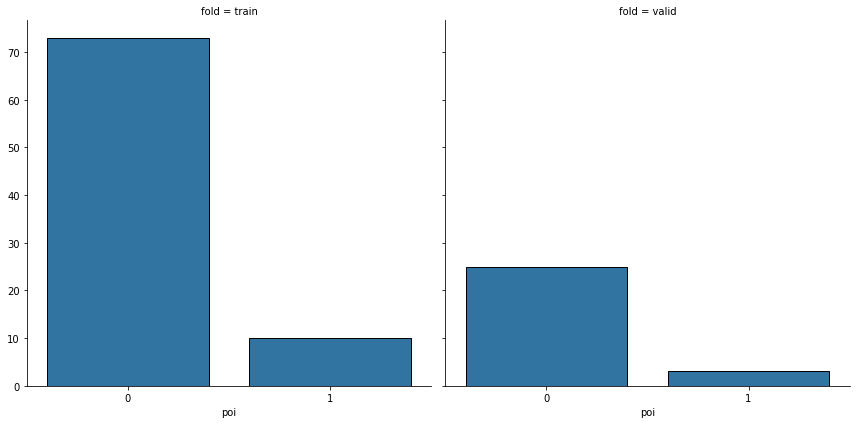

In [11]:
g = sns.FacetGrid(df_temp, col="fold", palette="Set1", col_wrap=2, height=6, aspect=1)
g.map(sns.countplot, 'poi', ec="k")
plt.show()

In [12]:
# model = ensemble.RandomForestClassifier(n_estimators=200)
model = xgboost.XGBClassifier(n_estimators=200)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
prediction_train = model.predict(X_train)
prob_train = model.predict_proba(X_train)[:, 1]

prediction_valid = model.predict(X_valid)
prob_valid = model.predict_proba(X_valid)[:, 1]

In [14]:
def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train_true, y_train_prob, pos_label=True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = metrics.confusion_matrix(y_train_true, y_train)
    acc_train = metrics.accuracy_score(y_train_true, y_train)
    auc_train = metrics.roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' % acc_train)
    print('Train AUC: %s ' % auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train+0.02, best_tpr_train+0.02, s = '(%.2f, %.2f)' % (best_fpr_train, best_tpr_train))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f' % auc_train)

    print("-"*50)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = metrics.confusion_matrix(y_test_true, y_test)
    acc_test = metrics.accuracy_score(y_test_true, y_test)
    auc_test = metrics.roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' % acc_test)
    print('Test AUC: %s ' % auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score+0.02, tpr_score+0.02, s = '(%.2f,%.2f)' % (fpr_score, tpr_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f' % auc_test)
    plt.savefig('ROC', dpi=500)
    plt.show()

    return best_threshold

Train Accuracy: 0.9879518072289156 
Train AUC: 0.95 
Train Confusion Matrix:
[[73  0]
 [ 1  9]]
--------------------------------------------------
Test Accuracy: 0.8928571428571429 
Test AUC: 0.5 
Test Confusion Matrix:
[[25  0]
 [ 3  0]]


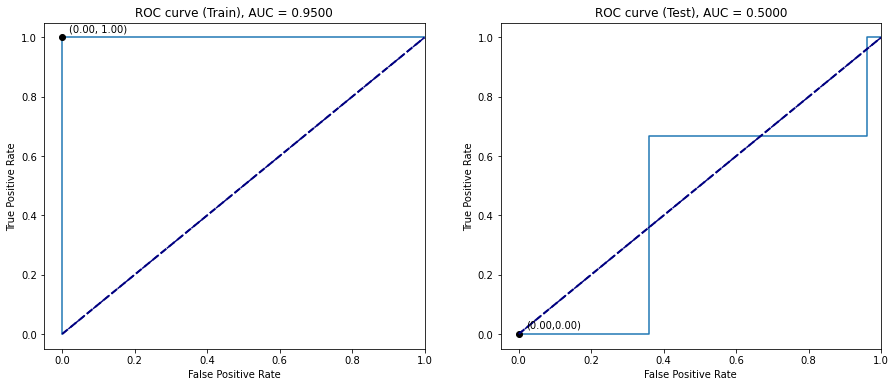

0.80455434

In [15]:
plot_ROC(y_train, prob_train, y_valid, prob_valid)

In [16]:
thres = 0.2
prediction_high_recall = (prob_train > thres).astype(int)
print(metrics.classification_report(y_train, prediction_high_recall))
print(metrics.confusion_matrix(y_train, prediction_high_recall))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        10

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

[[73  0]
 [ 0 10]]


In [17]:
meta_features = np.hstack((prediction_high_recall.reshape(-1, 1), X_train))
meta_labels = prediction_high_recall & y_train

In [18]:
meta_model = lightgbm.LGBMClassifier()
meta_model.fit(meta_features, meta_labels)

LGBMClassifier()

In [19]:
meta_prediction = meta_model.predict(meta_features)
final_prediction = meta_prediction & prediction_high_recall

In [20]:
print(metrics.classification_report(y_train, final_prediction))
print(metrics.confusion_matrix(y_train, final_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        10

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

[[73  0]
 [ 0 10]]


In [21]:
def meta_label_report(primary_model, secondary_model, X, y, threshold=0.5):
    # Primary model
    primary_prediction = primary_model.predict(X)
    print("BASE MODEL")
    print(metrics.classification_report(y, primary_prediction))
    print(metrics.confusion_matrix(y, primary_prediction))
    print("="*50)
    
    # Primary model with high recall
    prediction_hr = primary_model.predict_proba(X)[:, 1] > threshold
    print("BASE MODEL (HIGH RECALL)")
    print(metrics.classification_report(y, prediction_hr))
    print(metrics.confusion_matrix(y, prediction_hr))
    print("="*50)
    
    # Secondary model
    meta_features = np.hstack((prediction_hr.reshape(-1, 1), X))
    meta_prediction = secondary_model.predict(meta_features)
    final_prediction = (meta_prediction & prediction_hr)
    print("META MODEL")
    print(metrics.classification_report(y, final_prediction))
    print(metrics.confusion_matrix(y, final_prediction))

In [22]:
meta_label_report(model, meta_model, X_valid, y_valid, threshold=0.2)

BASE MODEL
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.00      0.00      0.00         3

    accuracy                           0.82        28
   macro avg       0.44      0.46      0.45        28
weighted avg       0.79      0.82      0.81        28

[[23  2]
 [ 3  0]]
BASE MODEL (HIGH RECALL)
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.00      0.00      0.00         3

    accuracy                           0.79        28
   macro avg       0.44      0.44      0.44        28
weighted avg       0.79      0.79      0.79        28

[[22  3]
 [ 3  0]]
META MODEL
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.00      0.00      0.00         3

    accuracy                           0.86        28
   macro avg       0.44      0.48      0.46

In [23]:
primary_prediction = model.predict(test_feature)

# Primary model with high recall
threshold = 0.2
prediction_hr = model.predict_proba(test_feature)[:, 1] > threshold

# Secondary model
meta_features = np.hstack((prediction_hr.reshape(-1, 1), test_feature))
meta_prediction = meta_model.predict(meta_features)
final_prediction = (meta_prediction & prediction_hr)

In [24]:
final_prediction

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [25]:
meta_proba = meta_model.predict_proba(meta_features)[:, 1]
meta_proba

array([7.30495806e-04, 1.17961475e-01, 8.49300211e-01, 4.90536767e-03,
       2.61354673e-01, 2.97057501e-02, 8.85533030e-01, 3.48100001e-01,
       8.86346007e-01, 5.60694119e-03, 5.25570187e-01, 3.45613536e-02,
       3.97175857e-01, 2.32267723e-01, 3.45702239e-01, 1.45386441e-02,
       6.59394302e-03, 2.29534896e-01, 5.79956450e-02, 9.92325860e-03,
       9.41742038e-01, 2.83022576e-01, 2.13061925e-01, 9.20797719e-01,
       3.20759383e-04, 8.46840137e-01, 2.52555347e-01, 1.84222424e-03,
       1.89110126e-04, 4.39559708e-01, 3.03582531e-02, 7.70381867e-02,
       4.00040849e-01])

In [26]:
submit = pd.read_csv("../data/sample_submission.csv")
submit['poi'] = meta_proba
submit.to_csv('../data/Submission_20201212_meta_labelling.csv', index=False)